In [0]:
# all config/downloads to use fastai
!pip install pandas --upgrade
!pip install plotly --upgrade
!pip install fastai==0.7.0
!pip install torchtext==0.2.3
!pip install torch
!pip install torchvision
!pip install Pillow>=4.1.1
!pip install image
!pip install matplotlib
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (3.7.0)


In [0]:

# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai.learner import *
from fastai.column_data import *
import copy
from torch.autograd import Variable as V

Train a simple initial model with fastai on the unfiltered, but normalized data set

In [0]:
PATH = "/content/drive/My Drive/fastai/"
df_scaled = pd.read_csv(PATH + 'music_ratings_normalized.csv')

In [0]:
val_idxs = get_cv_idxs(len(df_scaled))
wd=2e-2
n_factors = 20

In [0]:
# train cf model
cf = CollabFilterDataset.from_csv(PATH, 'music_ratings_normalized.csv', 'userID', 'artistID', 'weight')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [0]:
# fit the model
learn.fit(1e-2, 3, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      291.585878 296.731119
    1      97.410441  101.435788
    2      52.691627  97.794665 
 43%|████▎     | 500/1161 [00:04<00:05, 123.40it/s, loss=61.5]

KeyboardInterrupt: ignored

In [0]:
??fit


In [0]:
np.sqrt(50.65)

7.116881339463234

The average error on the unfiltered data set was about 7 points with the weights ranging around 0 and 80. This is the baseline model, and I will try to filter data and build a model to predict better than this baseline model.

Now, another model can be tried on a data set that has been filtered to improve the density of the set

In [0]:
filtered_df = pd.read_csv(PATH + 'music_ratings_filtscale.csv')

In [0]:
val_idxs = get_cv_idxs(len(filtered_df))
wd=1e-5
n_factors = 50

In [0]:
cf = CollabFilterDataset.from_csv(PATH, 'music_ratings_filtscale.csv', 'userID', 'artistID', 'weight')
learn = cf.get_learner(n_factors, val_idxs, 32, opt_fn=optim.Adam)

In [0]:
# fit the model
learn.fit(.08, 3, wds=wd, cycle_len=1, cycle_mult=2)

KeyboardInterrupt: ignored

In [0]:
np.sqrt(26.66)

5.163332257370234

As can be seen, the loss on the model has now decreased to an average of 5.16, where it was initially 7 with the less dense data set.

**Now that a decent model has been created, it can be built by scratch and compared to this previous model**

In [0]:
# create a custom class to handle data sets for the recommendation data
from torch.utils import data


# method for shuffling data in a data frame so that ordering
# is random during training
def shuffle_data(path, filename):
  df = pd.read_csv(path + filename)
  df = df.sample(frac=1)
  df.to_csv(path + filename, index=False)

In [0]:
# create the class that implements the recommendation model
from torch.autograd import Variable as V

class Recommender(nn.Module):
  def __init__(self, num_users, num_artists, num_factors):
    super().__init__()
    self.u = nn.Embedding(num_users, num_factors)
    self.a = nn.Embedding(num_artists, num_factors)
    self.u.weight.data.uniform_(-.01, .01)
    self.a.weight.data.uniform_(-.01, .01)
    self.ub = nn.Embedding(num_users, 1)
    self.ab = nn.Embedding(num_artists, 1)
    self.ub.weight.data.uniform_(-.01, .01)
    self.ab.weight.data.uniform_(-.01, .01)
    
  def forward(self, cats, conts):
    users, artists = cats[:,0],cats[:,1]
    us, art = self.u(users), self.a(artists)
    dp = (us*art).sum(1)
    dpb = dp + self.ub(users).squeeze() + self.ab(artists).squeeze()
    return dpb


In [0]:
# read in data frame created by EDA notebook
contig_df = pd.read_csv(PATH + "music_ratings_contig.csv")

In [0]:
# separate music data into separate training and testing files
shuffle_data(PATH, "music_ratings_contig.csv")
train_amt = .7
data_size = len(contig_df)
train_size = int(train_amt*data_size)
test_size = data_size - train_size

# get separate data frames with train and test data
train_data = contig_df.iloc[:train_size, :]
test_data = contig_df.iloc[train_size:, :]
print(f"{train_size} -> {len(train_data)}")
print(f"{test_size} -> {len(test_data)}")

# write these train and test data to separate csv file
train_data.to_csv(PATH + "music_train.csv", index=False)
test_data.to_csv(PATH + "music_test.csv", index=False)

49998 -> 49998
21428 -> 21428


In [0]:
# find number of artists and users being used1
num_users = contig_df.loc[:, "userID"].nunique()
num_artists = contig_df.loc[:, "artistID"].nunique()
print(num_users)
print(num_artists)

1881
2828


In [0]:
class RecDataset(data.Dataset):
  'Create custom class for pytorch data set'
  def __init__(self, path, file_name):
        'Initialization of data frame'
        self.data = pd.read_csv(path + file_name)

  def __len__(self):
        'find total number of samples'
        return self.data.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # get data sample from the data set
        return (np.array(self.data.loc[index, :]))

In [0]:
# check that data set class works properly
full_data = RecDataset(PATH, 'music_ratings_contig.csv')
print(full_data[0])
print(full_data[1])
print(full_data[2])
print(full_data[3])
print(full_data[4])
full_data.data.head()

[ 91.      124.       -0.14043]
[1154.       425.        -0.19586]
[1294.      1587.        -0.16284]
[1445.      1815.         0.01665]
[1039.        70.        -0.00717]


,userID,artistID,weight
0,91,124,-0.140434
1,1154,425,-0.195860
2,1294,1587,-0.162840
3,1445,1815,0.016647
4,1039,70,-0.007175


In [0]:
def get_loader(path, filename, bs):
  """method for getting a data loader from a csv file"""
  shuffle_data(path, filename)
  data_set = RecDataset(path, filename)
  data_loader = data.DataLoader(data_set, batch_size=bs, num_workers=2)
  return data_loader

In [0]:
""# create data loaders for training and test data
train_loader = get_loader(PATH, "music_train.csv", 32)
#next(iter(train_loader))

In [0]:
# declare the size of the embeddings to be used
num_factors = 40
wd = 1e-3
criterion = nn.MSELoss()

Find the optimal learning rate with which to begin training

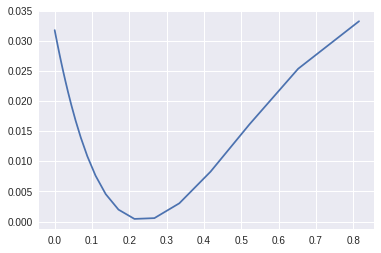

In [0]:
import matplotlib.pyplot as plt

losses = []
lrs = []

lr = 1e-6
practice_rec_model = Recommender(num_users, num_artists, num_factors)
opt = optim.SGD(practice_rec_model.parameters(), lr, weight_decay=wd, momentum=0.9)
while(lr <= 1):
  test_data = next(iter(train_loader))
  inputs = test_data[:, :2].long()
  expected = V(test_data[:, 2].float())
  
  opt.zero_grad()

  # run model
  outputs = practice_rec_model(inputs, None)
  loss = criterion(outputs, expected)
  loss.backward()
  opt.step()
  losses.append(loss.data[0])
  lrs.append(lr)
  
  # go to the next learning rate
  lr *= 1.25
  
  # change the learning rate in the optimizer
  for param_group in opt.param_groups:
        param_group['lr'] = lr
  
plt.plot(lrs, losses)

From this test, it can be seen that the optimal learning rate before loss starts increasing is around .1 so this will be the learning rate that will be used to begin training

In [0]:
training_loss = []

In [0]:
# declare training constants
n_epoch = 3
lr = .1

# declare loss criterion for the model
criterion = nn.MSELoss()

# create model and optimizer
recommender_model = Recommender(num_users, num_artists, num_factors).cuda()
opt = optim.SGD(recommender_model.parameters(), lr, weight_decay=wd, momentum=0.9)

**Create training loop to train the recommender model on test data**

In [0]:
train_loader = get_loader(PATH, "music_train.csv", 32)
for epoch in range(n_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, train_data in enumerate(train_loader):
        # get the inputs
        inputs = train_data.long().cuda()
        actual_out = V(train_data[:, 2].float()).cuda()

        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = recommender_model.forward(inputs, None)
        loss = criterion(outputs, actual_out)
        loss.backward()
        opt.step()

        # print statistics
        running_loss += loss.data[0]
        
        #input()
        if i % (len(train_loader)) == (len(train_loader) - 1):    # print every 2000 mini-batches
            training_loss.append((running_loss/len(train_loader)))
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss/len(train_loader)}")
            #epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    

print('Finished Training')

[1, 1563] loss: 0.9988490516434275
[2, 1563] loss: 0.9849060274036726
[3, 1563] loss: 0.984226661279943
Finished Training


Continue training while reducing the learning rate to arrive at an optimal solution

In [0]:
# decrease the learning rate then train model again
lr = .001
opt = optim.SGD(recommender_model.parameters(), lr, weight_decay=wd, momentum=0.9)

In [0]:
train_loader = get_loader(PATH, "music_train.csv", 32)
for epoch in range(n_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, train_data in enumerate(train_loader):
        # get the inputs
        inputs = train_data.long().cuda()
        actual_out = V(train_data[:, 2].float()).cuda()

        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = recommender_model.forward(inputs, None)
        loss = criterion(outputs, actual_out)
        loss.backward()
        opt.step()

        # print statistics
        running_loss += loss.data[0]
        #input()
        if i % (len(train_loader)) == (len(train_loader) - 1):    # print every 2000 mini-batches
            training_loss.append((running_loss/len(train_loader)))
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss/len(train_loader)}")
            #epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    

print('Finished Training')

[1, 1563] loss: 0.7607860005682934
[2, 1563] loss: 0.7595202427903239
[3, 1563] loss: 0.7582918316684782
Finished Training


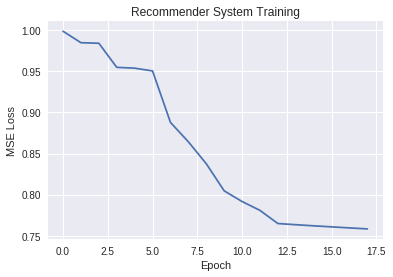

In [0]:
plt.title("Recommender System Training")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.plot(training_loss)

In [0]:
# decrease the learning rate then train model again
n_epoch = 6
lr =5e-3
opt = optim.SGD(recommender_model.parameters(), lr, weight_decay=wd, momentum=0.9)

In [0]:
train_loader = get_loader(PATH, "music_train.csv", 32)
for epoch in range(n_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, train_data in enumerate(train_loader):
        # get the inputs
        inputs = train_data.long().cuda()
        actual_out = V(train_data[:, 2].float()).cuda()

        # zero the parameter gradients
        opt.zero_grad()

        # forward + backward + optimize
        outputs = recommender_model.forward(inputs, None)
        loss = criterion(outputs, actual_out)
        loss.backward()
        opt.step()

        # print statistics
        running_loss += loss.data[0]
        #input()
        if i % (len(train_loader)) == (len(train_loader) - 1):    # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss/len(train_loader)}")
            #epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    

print('Finished Training')

The model seems to have converged around a loss of .3, so now the validation error can be considered

In [0]:
test_loader = get_loader(PATH, 'music_test.csv', 32)
for i, test_data in enumerate(test_loader):
    inputs = test_data.long().cuda()
    actual_out = V(test_data[:, 2].float()).cuda()
    # get prediction from recommender
    pred = recommender_model(inputs, None)
    loss = criterion(pred, actual_out)
    running_loss += loss.data[0]

print(f"Validation MSE: {running_loss/len(test_loader)}")

Validation MSE: 0.9591402612376346


In [0]:
# save the model to be used later
torch.save(recommender_model.state_dict(), PATH + "custom_model")

In [0]:
# find number of artists and users being used1
MODEL_PATH = "/content/drive/My Drive/fastai/custom_model"

num_users = contig_df.loc[:, "userID"].nunique()
num_artists = contig_df.loc[:, "artistID"].nunique()
rec_model = Recommender(num_users, num_artists, 40)
rec_model.load_state_dict(torch.load(MODEL_PATH))

In [0]:
# get dictionaries that contain index mappings to study embeddings
import pickle
user_to_index_dict = pickle.load(open(PATH + "user_to_index_dict.txt", "rb"))
index_to_user_dict = pickle.load(open(PATH + "index_to_user_dict.txt", "rb"))
artist_to_index_dict = pickle.load(open(PATH + "artist_to_index_dict.txt", "rb"))
index_to_artist_dict = pickle.load(open(PATH + "index_to_artist_dict.txt", "rb"))

In [0]:
# get the dataframe of artists mapped to IDs
import pandas as pd
artist_df = pd.read_csv(PATH + 'artists_cleaned.csv')
artist_df.head()

,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


In [0]:
# get data from artist embeddings into a numpy array
np_artist_embedding = rec_model.ab.weight.data.numpy()

In [0]:
np_embed = np.array(np_artist_embedding, copy=True)

In [0]:
np_embed.sort(axis=0)
np_embed

array([[-0.11609],
       [-0.10077],
       [-0.08861],
       ...,
       [ 0.58359],
       [ 0.82891],
       [ 0.95887]], dtype=float32)

In [0]:
# find the 5 largest values to see which artists they are for
best_indices = np.argsort(np_artist_embedding, axis=0)[-5:, :]
best_indices

array([[320],
       [ 92],
       [330],
       [156],
       [ 19]])

In [0]:
# take indices and convert to the indices for embedding
for i in range(best_indices.shape[0]):
  best_indices[i, :] = index_to_artist_dict[best_indices[i, :].item()]

In [0]:
best_indices

array([[498],
       [203],
       [511],
       [289],
       [ 72]])

In [0]:
sorted_embeddings = np.sort(np_artist_embedding, axis=0)
best_embeddings = sorted_embeddings[-5:, :]

In [0]:
best_artists = []
for i in range(5):
  artist = best_indices[i, :].item()
  artist_name = artist_df.loc[artist_df["id"] == artist].iloc[:, 1].item()
  artist_embedding = best_embeddings[i, :].item()
  best_artists.append((artist_name, artist_embedding))

In [0]:
best_artists = [i for i in reversed(best_artists)]

In [0]:
best_artists

[(' Depeche Mode', 0.9588698744773865),
 (' Britney Spears', 0.8289055228233337),
 (' U2', 0.5835899710655212),
 (' Blur', 0.503320038318634),
 (' Paramore', 0.4168234169483185)]

In [0]:
# basic matrix factorization model without bias term
class Recommender(nn.Module):
  def __init__(self, num_users, num_artists, num_factors):
    super().__init__()
    self.u = nn.Embedding(num_users, num_factors)
    self.a = nn.Embedding(num_artists, num_factors)
    self.u.weight.data.uniform_(-.01, .01)
    self.a.weight.data.uniform_(-.01, .01)
    
  def forward(self, cats, conts):
    users, artists = cats[:,0], cats[:,1]
    us, art = self.u(users), self.a(artists)
    return (us*art).sum(1)